# Simulating DESI Spectra

The goal of this notebook is to demonstrate how to generate some simple DESI spectra using the `quickspectra` utility.  For simplicity we will only generate 1D spectra and skip the more computationally intensive (yet still instructive!) step of extracting 1D spectra from simulated 2D spectra (i.e., so-called "pixel-level simulations").  In this tutorial we will:

  * generate 100 random QSO spectra
  * simulate them under dark time conditions
  * plot the truth and the noisy simulated spectra
  * run redshift fitting
  * re-simulate when the moon is quite bright
  * re-run redshift fitting
  * compare redshift performance with and without moon

The heart of `quickspectra` is the `SpecSim` package, which you can read out here:  
http://specsim.readthedocs.io/en/stable

If you identify any errors or have requests for additional functionality please create a new issue on  
https://github.com/desihub/desisim/issues
or send a note to <desi-data@desi.lbl.gov>.

## Getting started.

See https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC to configure a jupyter server at NERSC with pre-installed DESI code.  This notebook was tested with the "desi master" kernel.  The `quickspectra` utility was not included in the desi 17.9 release, but it will be included in the next release (17.12?).

Alternately, see https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop for instructions to install code locally.

First, import all the package dependencies.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
import desispec.io
import desisim.io
import desisim.templates
from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desispec.scripts import group_spectra

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Simulate with quickspectra

The simplest way to simulate spectra is using the `quickspectra` script.  We'll generate a set of noiseless template spectra, save them to a file, and then run `quickspectra` to simulate noise and write out a file that can be used as input for redshift fitting.

### Start by simulating some QSO spectra

In [4]:
qso_maker = desisim.templates.QSO()
truth = flux, wave, meta = qso_maker.make_templates(nmodel=100)

### Write those to a file and run quickspectra

In [5]:
simdir = os.getenv('SCRATCH') + '/desi/simspec'
os.makedirs(simdir, exist_ok=True)
infile = simdir + '/qso-input-spectra.fits'
hdr = fits.Header()
hdr['EXTNAME'] = 'WAVELENGTH'
hdr['BUNIT'] = 'Angstrom'
fits.writeto(infile, wave, header=hdr, clobber=True)
hdr['EXTNAME'] = 'FLUX'
hdr['BUNIT'] = '10^-17 ergs/s/cm2/A'
fits.append(infile, flux, header=hdr)

In [6]:
specoutfile = simdir + '/qso-observed-spectra.fits'
cmd = 'quickspectra -i {} -o {}'.format(infile, specoutfile)
print(cmd)
!$cmd

quickspectra -i /global/cscratch1/sd/sjbailey/desi/simspec/qso-input-spectra.fits -o /global/cscratch1/sd/sjbailey/desi/simspec/qso-observed-spectra.fits
INFO:quickspectra.py:260:main: Reading an input FITS file
INFO:quickspectra.py:295:main: input flux shape = (100, 32001)
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 100 spectra
DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:408:simulate_spectra: obsconditions EXPTIME = 1000.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:408:sim

### Let's see what we got

In [7]:
spectra = desispec.io.read_spectra(specoutfile)

In [8]:
from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, nfilter=11):
    plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), 'b', alpha=0.5)
    plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), 'r', alpha=0.5)
    plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), 'k', alpha=0.5)
    if truewave is not None and trueflux is not None:
        plot(truewave, trueflux[i], 'k-')

    ymin = ymax = 0.0
    for x in ['b', 'r', 'z']:
        tmpmin, tmpmax = np.percentile(spectra.flux['r'][i], [1, 99])
        ymin = min(tmpmin, ymin)
        ymax = max(tmpmax, ymax)
        
    ylim(ymin, ymax)
    ylabel('flux [1e-17 erg/s/cm2/A]')
    xlabel('wavelength [A]')

# plotspec(spectra, 0, wave, flux)

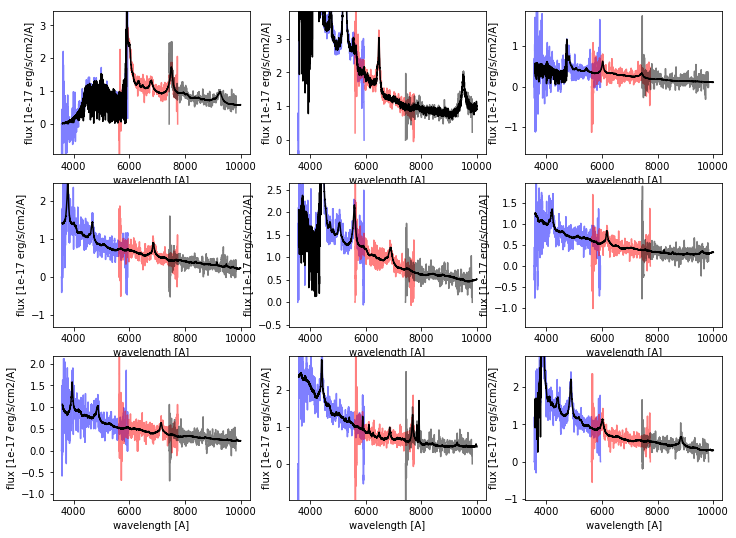

In [9]:
figure(figsize=(12,9))
for i in range(9):
    subplot(3,3,i+1)
    plotspec(spectra, i, wave, flux)

## Fit redshifts

If at NERSC, run this via an interactive batch node so that we don't abuse the single jupyter server node.

In [10]:
zoutfile = simdir + '/qso-zbest.fits'
cmd = 'rrdesi {} --zbest {}'.format(specoutfile, zoutfile)
if 'NERSC_HOST' in os.environ:
    srun = 'srun -N 1 -t 00:10:00 -C haswell --qos interactive'
    cmd = '{srun} {cmd} --ncpu 32'.format(srun=srun, cmd=cmd)

!$cmd

srun: job 8751670 queued and waiting for resources
srun: job 8751670 has been allocated resources
INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-star-A.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-star-B.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-star-M.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-galaxy.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/r

In [11]:
zbest = Table.read(zoutfile)

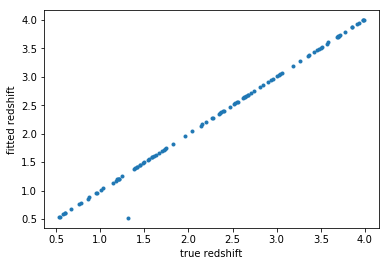

In [12]:
plot(meta['REDSHIFT'], zbest['Z'], '.')
xlabel('true redshift'); ylabel('fitted redshift')

### Re-simulate with the moon up

In [13]:
specoutfile_moon = simdir + '/qso-moon-spectra.fits'
cmd = 'quickspectra -i {} -o {} --moonfrac 0.9 --moonalt 80 --moonsep 20'.format(infile, specoutfile_moon)
print(cmd)
!$cmd

quickspectra -i /global/cscratch1/sd/sjbailey/desi/simspec/qso-input-spectra.fits -o /global/cscratch1/sd/sjbailey/desi/simspec/qso-moon-spectra.fits --moonfrac 0.9 --moonalt 80 --moonsep 20
INFO:quickspectra.py:260:main: Reading an input FITS file
INFO:quickspectra.py:295:main: input flux shape = (100, 32001)
INFO:quickspectra.py:47:sim_spectra: Starting simulation of 100 spectra
DEBUG:simexp.py:379:simulate_spectra: loading specsim desi config
DEBUG:simexp.py:383:simulate_spectra: creating specsim desi simulator
DEBUG:specsim.py:39:get_simulator: Creating new  Simulator
INFO:simexp.py:404:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONALT = 80.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions MOONSEP = 20.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions EXPTIME = 1000.0
DEBUG:simexp.py:408:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:408:simulate_spectra: obsconditions

In [14]:
zoutfile_moon = simdir + '/qso-zbest-moon.fits'
cmd = 'rrdesi {} --zbest {}'.format(specoutfile_moon, zoutfile_moon)
if 'NERSC_HOST' in os.environ:
    srun = 'srun -N 1 -t 00:10:00 -C haswell --qos interactive'
    cmd = '{srun} {cmd} --ncpu 32'.format(srun=srun, cmd=cmd)

print(cmd)
!$cmd

srun -N 1 -t 00:10:00 -C haswell --qos interactive rrdesi /global/cscratch1/sd/sjbailey/desi/simspec/qso-moon-spectra.fits --zbest /global/cscratch1/sd/sjbailey/desi/simspec/qso-zbest-moon.fits --ncpu 32
srun: job 8751722 queued and waiting for resources
srun: job 8751722 has been allocated resources
INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-star-A.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-star-B.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/redrock-templates/master/rrtemplate-star-M.fits, using default values
INFO: Can't find redshift range info in template file /global/common/cori/contrib/desi/desiconda/current/code/re

In [15]:
zbest_moon = Table.read(zoutfile_moon)

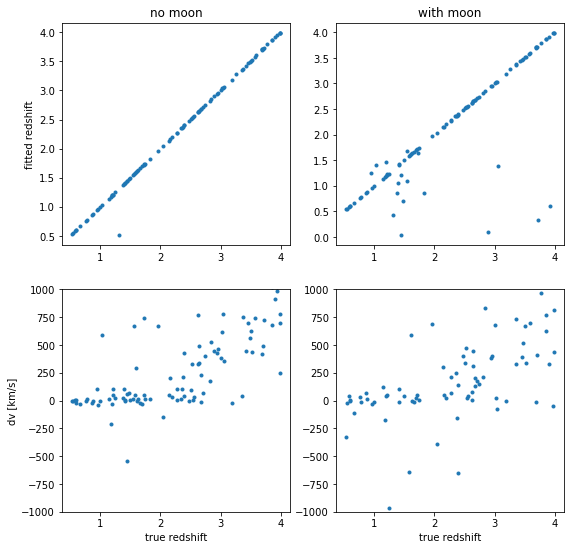

In [16]:
figure(figsize=(9,9))

subplot(221)
plot(meta['REDSHIFT'], zbest['Z'], '.')
ylabel('fitted redshift')
title('no moon')

subplot(222)
plot(meta['REDSHIFT'], zbest_moon['Z'], '.')
title('with moon')

subplot(223)
dv = 3e5*(zbest['Z'] - meta['REDSHIFT'])/(1+meta['REDSHIFT'])
plot(meta['REDSHIFT'], dv, '.')
ylim(-1000, 1000)
ylabel('dv [km/s]')
xlabel('true redshift')

subplot(224)
dv = 3e5*(zbest_moon['Z'] - meta['REDSHIFT'])/(1+meta['REDSHIFT'])
plot(meta['REDSHIFT'], dv, '.')
ylim(-1000, 1000)
xlabel('true redshift')

### Post-mortem

Note that we have a distinct redshift bias above z>2.5 which corresponds
to when MgII redshifts off the end of the spectrographs.

Volunteers to help work on this?

## Appendix: Code versions

In [17]:
from desitutorials import print_code_versions
print("This tutorial last ran successfully to completion using the following versions of the following modules:") 
print_code_versions()

This tutorial last ran successfully to completion using the following versions of the following modules:
python      : 3.5.3
numpy       : 1.11.3
scipy       : 0.19.0
astropy     : 1.3.3
yaml        : 3.12
matplotlib  : 2.0.2
fitsio      : 0.9.11
healpy      : 1.10.3
desiutil    : 1.9.8.dev573
desispec    : 0.17.0.dev1927
desitarget  : 0.16.2.dev1345
desimodel   : 0.9.1.dev318
desisim     : 0.22.0.dev1184
redrock     : 0.6.0dev1
specter     : 0.8.1dev1
speclite    : 0.5


## Appendix: quickgen

This tutorial focused on quickspectra, which simulates spectra outside of the context
of the full spectroscopic pipeline.  A separate tutorial (from June 2016, possibly out-of-date)
covers the use of `quickgen` which can write out intermediate pipeline steps, e.g. non-skysubtracted
non-fluxcalibrated spectra, and then proceed with the real spectro pipeline.  That method is
mostly for people working on developing the spectro pipeline itself.